In [6]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import seaborn as sb
import math

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
#load dataset

path='/gpfs/alpine/cli900/world-shared/users/zaneb/microPhys/kessler_ml_data_flat.nc'
ds=nc.Dataset(path)
#prints variable names and dimensions
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Dataset'>
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_theta(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qc(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qv(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_qr(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_rho_dry(nsamples, three)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000, 3)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64 ml_in_z(nsamples)
    _FillValue: nan
unlimited dimensions: 
current shape = (24000000,)
filling on
<class 'netCDF4._netCDF4.Variable'>
float64

In [6]:
def dataOp2(theta_in, theta_out, qv_in, qv_out, qc_in, qc_out, qr_in, qr_out, delta):
    #Function to identify op/no-op values and identify them with boolean
    #returns two lists of booleans
    print("Inside dataOp2()", delta)
    
    opmask = np.zeros(24000000, dtype=bool)
    nopmask = np.zeros(24000000, dtype=bool)
    opcount=0
    nopcount=0
    #delta = 1E-8
    for i in range(24000000):
        if ( np.abs(theta_in[i]-theta_out[i]) > delta ) or \
           ( np.abs(qv_in[i]-qv_out[i]) > delta ) or \
           ( np.abs(qc_in[i]-qc_out[i]) > delta ) or \
           ( np.abs(qr_in[i]-qr_out[i]) > delta ):
            opcount+=1
            opmask[i] = True
    print(opcount)

    for i in range(24000000):
        if ( np.abs(theta_in[i]-theta_out[i]) < delta ) and \
           ( np.abs(qv_in[i]-qv_out[i]) < delta ) and \
           ( np.abs(qc_in[i]-qc_out[i]) < delta ) and \
           ( np.abs(qr_in[i]-qr_out[i]) < delta ):
            nopcount+=1
            nopmask[i] = True
    print(opcount, nopcount, opcount+nopcount)
    
    print('--------------------------------Total no-op Variable sums-----------------------------')
    print( "[qc]-----in: ", np.sum(np.abs(qc_in[nopmask2])),'-----out:', np.sum(np.abs(qc_out[nopmask2])) )
    print( "[qv]-----in: ", np.sum(np.abs(qv_in[nopmask2])),'-----out:', np.sum(np.abs(qv_out[nopmask2])) )
    print( "[qr]-----in: ", np.sum(np.abs(qr_in[nopmask2])),'-----out:', np.sum(np.abs(qr_out[nopmask2])) )

    print('---------------------------------Total change in no-op variables------------------------')
    print( "[dqc] ", np.sum( np.abs(qc_in[nopmask2] - qc_out[nopmask2]) ) )
    print( "[dqv] ", np.sum( np.abs(qv_in[nopmask2] - qv_out[nopmask2]) ) )
    print( "[dqr] ", np.sum( np.abs(qr_in[nopmask2] - qr_out[nopmask2]) ) )

    print('--------------------------------Total op Variable sums----------------------------------')
    print( "[qc]-----in: ", np.sum(np.abs(qc_in[opmask2])),'-----out:', np.sum(np.abs(qc_out[opmask2])) )
    print( "[qv]-----in: ", np.sum(np.abs(qv_in[opmask2])),'-----out:', np.sum(np.abs(qv_out[opmask2])) )
    print( "[qr]-----in: ", np.sum(np.abs(qr_in[opmask2])),'-----out:', np.sum(np.abs(qr_out[opmask2])) )

    print('---------------------------------Total change in op variables------------------------')
    print( "[dqc] ", np.sum( np.abs(qc_in[opmask2] - qc_out[opmask2]) ) )
    print( "[dqv] ", np.sum( np.abs(qv_in[opmask2] - qv_out[opmask2]) ) )
    print( "[dqr] ", np.sum( np.abs(qr_in[opmask2] - qr_out[opmask2]) ) )
        
    return opmask, nopmask


num1, num2 = 0, 24000000
theta_in = ds['ml_in_theta'][:,1]
qc_in = ds['ml_in_qc'][num1:num2,1]
qv_in = ds['ml_in_qv'][num1:num2,1]
qr_in = ds['ml_in_qr'][num1:num2,1]
rho_dry_in = ds['ml_in_rho_dry'][num1:num2,1]
z_in = ds['ml_in_z'][num1:num2]
exner_in = ds['ml_in_exner'][num1:num2,1]
theta_out = ds['ml_out_theta'][num1:num2]
qc_out = ds['ml_out_qc'][num1:num2]
qv_out = ds['ml_out_qv'][num1:num2]
qr_out = ds['ml_out_qr'][num1:num2]

delta = 1E-16
opmask2, nopmask2 = dataOp2(theta_in, theta_out, qv_in, qv_out, qc_in, qc_out, qr_in, qr_out, delta)
print("[dop2] ", np.sum(opmask2), np.sum(nopmask2), delta)



Inside dataOp2() 1e-16
1702636
1702636 22297364 24000000
[dop2]  1702636 22297364 1e-16
--------------------------------Total no-op Variable sums-----------------------------
[qc]-----in:  2.974747786606549e-13 -----out: 0.0
[qv]-----in:  52089.97395831689 -----out: 52089.9739583169
[qr]-----in:  1.7362233776116805e-13 -----out: 2.38755e-318
---------------------------------Total change in no-op variables------------------------
[dqc]  2.974747786606549e-13
[dqv]  5.351217651503384e-13
[dqr]  1.7362233776116805e-13
--------------------------------Total op Variable sums----------------------------------
[qc]-----in:  141.7148585429016 -----out: 140.65517154588522
[qv]-----in:  5001.335752187428 -----out: 4961.927093145766
[qr]-----in:  603.1845752986519 -----out: 598.0151605888512
---------------------------------Total change in op variables------------------------
[dqc]  26.309639413255496
[dqv]  60.63209451999513
[dqr]  121.72817254607185


In [11]:
def toDF(ds,num1,num2,opmask2):
    #Function to transform dataset into dataframe
    #takes in dataset, two ints to control the range/number
    #of samples to be included, and list of booleans for op/no-op
    #returns ds as a dataframe



    inputs={ 'theta': ds['ml_in_theta'][num1:num2,1],
           'qc': ds['ml_in_qc'][num1:num2,1],
           'qv': ds['ml_in_qv'][num1:num2,1],
           'qr': ds['ml_in_qr'][num1:num2,1],
           'rho_dry': ds['ml_in_rho_dry'][num1:num2,1],
           'z': ds['ml_in_z'][num1:num2],
           'exner': ds['ml_in_exner'][num1:num2,1],
           'theta_out': ds['ml_out_theta'][num1:num2],
           'qc_out': ds['ml_out_qc'][num1:num2],
           'qv_out': ds['ml_out_qv'][num1:num2],
           'qr_out': ds['ml_out_qr'][num1:num2],
           'operation': opmask2[num1:num2]}

    df=pd.DataFrame(inputs,columns=['theta','qc','qv','qr','rho_dry','z','exner','theta_out','qc_out','qv_out','qr_out', 'operation'])

    #df.head()
    
    return df

def minMaxScale(df):
    #Scales dataframe using min-max normalization
    #returns scaled dataframe
    
    scaler=MinMaxScaler(copy=False)
    df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']]=scaler.fit_transform(df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']])

    return df

def mixSamples(df,nopVal):
    #function to mix op/no-op samples
    #takes in dataframe and vaulue for number of no-op samples to
    #mix the op samples. For nopVal<1: there are more no-op samples in the dataset
    #For nopVal>1, there are more no-op samples in the dataset
    #returns mixed op/no-op df
    
    opDF=df[(df['operation']==True)]
    nopDF=df[(df['operation']!=True)]
    mixDF=opDF.copy()
    #most likely a better/prettier method for this step:
    mixDF=mixDF.append(nopDF.sample(int(nopPer*len(opDF))))
    print('op/no-op ratio=',len(mixDF[mixDF['operation']==True])/len(mixDF[mixDF['operation']==False]))
    
    return mixDF

In [12]:

df=toDF(ds,0,24000000,opmask2)

x1=mixDF[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y1=mixDF[['operation']]

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1, y1, test_size=0.30, random_state=10)


NameError: name 'opmask2' is not defined

<AxesSubplot:>

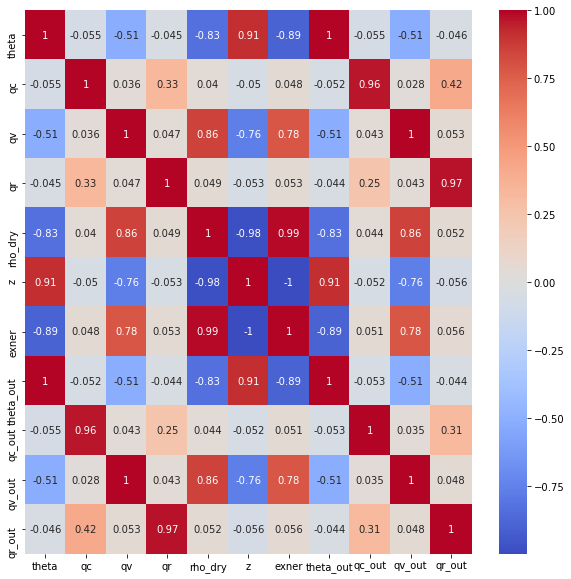

In [13]:
#creates correlation matrix for operation data
plt.figure(figsize=(10,10))
sb.heatmap(df.corr(),annot=True, cmap='coolwarm')

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

stopTol=1e-5
ytrain1=ytrain1.values.ravel()
ytest1=ytest1.values.ravel()

lr=LogisticRegression(dual=False,tol=stopTol,random_state=0,verbose=True)
sgd=SGDClassifier(verbose=True,random_state=0,early_stopping=True)
svc=LinearSVC(dual=False,tol=stopTol,verbose=True,random_state=0)
dtc=DecisionTreeClassifier(min_samples_split=20,random_state=0)
mlp=MLPClassifier(hidden_layer_sizes=[100,100,100,100,100,100],tol=stopTol,early_stopping=True,verbose=True)

In [9]:
#Classification Models

def logRegress(xtrain,ytrain,xtest,ytest,tol,verb):
    #function to perform logistic regression on xtrain/ytrain,
    #tests on xtest/ytest, and print scores
    #takes in train/test sets, stopping tolerence, and boolean
    #for verbose training
    #returns model predictions for ytest
    
    print('-----Logistic Regression-----')
    lr=LogisticRegression(dual=False,tol=tol,random_state=0,verbose=verb)
    lr.fit(xtrain,ytrain)
    print('accuracy score=',lr.score(xtest,ytest))
    plot_confusion_matrix(lr,xtest,ytest,normalize='all')
    ypred=lr.predict(xtest)
    
    return ypred

def sgdClass(xtrain,ytrain,xtest,ytest,verb,es):
    #function to perform stochastic gradient decent classification
    #on xtrain/ytrain, test on xtest/ytest, and print scores
    #takes in train/test sets, boolean
    #for verbose training, and boolean for early stopping
    #returns model predictions for ytest
    
    print('-----SGD Classifier-----')
    sgd=SGDClassifier(verbose=verb,random_state=0,early_stopping=es)
    sgd.fit(xtrain,ytrain)
    print('accuracy score=',sgd.score(xtest,ytest))
    plot_confusion_matrix(sgd,xtest,ytest,normalize='all')
    ypred=sgd.predict(xtest)
    
    return ypred

def SVC(xtrain,ytrain,xtest,ytest,tol,verb):
    #funtion to perform support vector classification on xtrain/train, 
    #test on xtest/ytest, and print scores
    #takes in train/test sets, stopping tolerance, and boolean for vebose training
    #returns model predictions for xtest
    
    print('-----SVC-----')
    svc=LinearSVC(dual=False,tol=tol,verbose=verb,random_state=0)
    svc.fit(xtrain,ytrain)
    print('accuracy score=',svc.score(xtest,ytest))
    plot_confusion_matrix(svc,xtest,ytest,normalize='all')
    ypred=svc.predict(xtest)
    
    return ypred

def dtClass(xtrain,ytrain,xtest,ytest,minSplit):
    #function to perform decision tree classification on xtrain/ytrain,
    #test on xtest/ytest, and print scores
    #takes in train/tests sets and int to indicate the minimum samples needed to split
    #return model predictions for xtest
    
    print('-----DT Classifier-----')
    dtc=DecisionTreeClassifier(min_samples_split=minSplit,random_state=0)
    dtc.fit(xtrain,ytrain)
    print('accuracy score=',dtc.score(xtest,ytest))
    plot_confusion_matrix(dtc,xtest,ytest,normalize='all')
    ypred=dtc.predict(xtest)
    
    return ypred

def nnClass(xtrain,ytrain,xtest,ytest,layers,act,lr,tol,es,verb):
    #function to perform classification with neural network, 
    #test on xtest/ytest, and print scores
    #takes in train/test sets, array for number/size of layers,
    #a string for the activation function, learning rate, stopping tolerence,
    #and two booleans for early stopping and verbose training
    print('-----NN Classifier-----')
    print('Number of hidden layers:',len(layers),'-----hidden layer sizes:',layers)
    mlp=MLPClassifier(hidden_layer_sizes=layers,activation=act, learning_rate_init=lr,tol=tol,early_stopping=es,verbose=verb)
    mlp.fit(xtrain1,ytrain1)
    print('accuracy score=',mlp.score(xtest1,ytest1))
    plot_confusion_matrix(mlp,xtest1,ytest1,normalize='all')

    ypred=mlp.predict(xtest)
    
    return ypred

In [10]:
#Regression Models

def linRegress():
    #function to perform linear regression on xtrain/ytrain,
    #test on xtest/ytest, and print results
    #takes in train/test set, returns predictions for xtest
    
    linReg=LinearRegression()
    linReg.fit(xtrain,ytrain)
    ypred=linReg.predict(xtest)

    print('-----Linear Regressor-----')
    print('# features:', linReg.rank_,)
    print('MAE test scores ----- AVG=',mean_absolute_error(ytest,ypred),'----- by variable:',mean_absolute_error(ytest,ypred,multioutput='raw_values'))
    
    return ypred

def dtRegress(xtrain,ytrain,xtest,ytest,minSplit,crit):
    #function to perform decision tree regression on xtrain/ytrain,
    #test on xtest/ytest, and print the results
    #Takes in train/test datasets, int for the minimum samples to split,
    #and string for split criterion ('mse' or 'mae')
    #returns model predictions for xtest
    
    dtr=DecisionTreeRegressor(min_samples_split=20,random_state=0,criterion=crit)
    dtr.fit(xtrain,ytrain)
    ypred=dtr.predict(xtest)

    print('-----DT Regressor-----')
    print('# features:',dtr.n_features_,'-----','# outputs:',dtr.n_outputs_)
    print('MAE test scores ----- AVG=',mean_absolute_error(ytest,ypred),'----- by variable:',mean_absolute_error(ytest,ypred,multioutput='raw_values'))

    return ypred

def nnRegress(xtrain,ytrain,xtest,ytest,layers,act,lr,tol,es,verb):
    #function to perform regression on xtrain/ytrain using neural network,
    #test on xtest/ytest, and print results
    #Takes in train/test sets, array for number of layers and nodes, activation function,
    #learnig rate, stopping tolerance, boolean for early stopping, and boolean for verbose
    #Returns model predictions for xtest
    
    mlp=MLPRegressor(hidden_layer_sizes=layers,tol=tol,early_stopping=es,verbose=verb)
    mlp.fit(xtrain,ytrain)
    ypred=mlp.predict(x)
    
    print('-----NN Regressor-----')
    print('Number of hidden layers:', len(layers),'-----hidden layer sizes:',layers)
    print('# of Iterations:',mlpReg.n_iter_,'-----','Final Training Loss=',mlpReg.loss_)
    print('MAE test scores ----- AVG=',mean_absolute_error(ytest,ypred),'----- by variable:',mean_absolute_error(ytest,ypred,multioutput='raw_values'))
    
    return ypred

Iteration 1, loss = 0.49445105
Validation score: 0.693064
Iteration 2, loss = 0.48181703
Validation score: 0.672071
Iteration 3, loss = 0.45677289
Validation score: 0.775743
Iteration 4, loss = 0.42070539
Validation score: 0.784494
Iteration 5, loss = 0.41319554
Validation score: 0.801044
Iteration 6, loss = 0.39231554
Validation score: 0.807047
Iteration 7, loss = 0.37991353
Validation score: 0.812874
Iteration 8, loss = 0.37777423
Validation score: 0.816612
Iteration 9, loss = 0.37206977
Validation score: 0.816977
Iteration 10, loss = 0.37180725
Validation score: 0.823236
Iteration 11, loss = 0.37123951
Validation score: 0.808100
Iteration 12, loss = 0.37029746
Validation score: 0.808339
Iteration 13, loss = 0.36551103
Validation score: 0.794453
Iteration 14, loss = 0.36308320
Validation score: 0.779963
Iteration 15, loss = 0.36094068
Validation score: 0.830209
Iteration 16, loss = 0.35975019
Validation score: 0.827050
Iteration 17, loss = 0.35885692
Validation score: 0.821944
Iterat

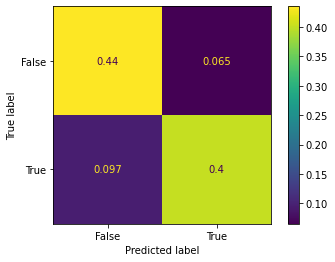

In [10]:
mlp.fit(xtrain1,ytrain1)
print('accuracy score=',mlp.score(xtest1,ytest1))
plot_confusion_matrix(mlp,xtest1,ytest1,normalize='all')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/ccs/home/zaneb/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min finished


accuracy score= 0.9338642272882032


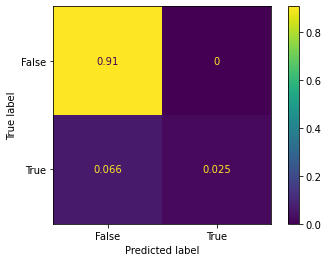

In [65]:
lr.fit(xtrain1,ytrain1)
print('accuracy score=',lr.score(xtest1,ytest1))
plot_confusion_matrix(lr,xtest1,ytest1,normalize='all')

-- Epoch 1
Norm: 11.57, NNZs: 7, Bias: -0.978732, T: 11799267, Avg. loss: 0.145537
Total training time: 2.27 seconds.
-- Epoch 2
Norm: 11.57, NNZs: 7, Bias: -0.998602, T: 23598534, Avg. loss: 0.144442
Total training time: 6.30 seconds.
-- Epoch 3
Norm: 11.57, NNZs: 7, Bias: -1.005108, T: 35397801, Avg. loss: 0.144410
Total training time: 10.32 seconds.
-- Epoch 4
Norm: 11.57, NNZs: 7, Bias: -1.007562, T: 47197068, Avg. loss: 0.144395
Total training time: 14.35 seconds.
-- Epoch 5
Norm: 11.57, NNZs: 7, Bias: -1.008755, T: 58996335, Avg. loss: 0.144386
Total training time: 18.37 seconds.
-- Epoch 6
Norm: 11.57, NNZs: 7, Bias: -1.009398, T: 70795602, Avg. loss: 0.144380
Total training time: 22.40 seconds.
Convergence after 6 epochs took 24.16 seconds
accuracy score= 0.9175905311888036


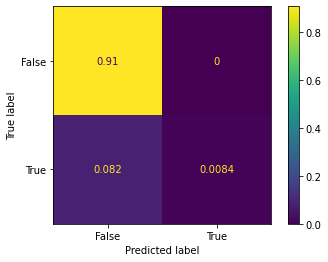

In [66]:
sgd.fit(xtrain1,ytrain1)
print('accuracy score=',sgd.score(xtest1,ytest1))
plot_confusion_matrix(sgd,xtest1,ytest1,normalize='all')

[LibLinear]accuracy score= 0.9372198083577711


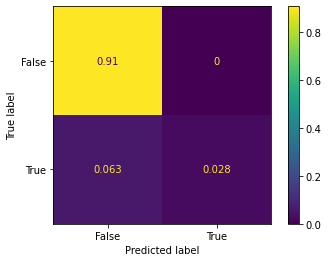

In [67]:
svc.fit(xtrain1,ytrain1)
print('accuracy score=',svc.score(xtest1,ytest1))
plot_confusion_matrix(svc,xtest1,ytest1,normalize='all')

accuracy score= 0.9674700495612952


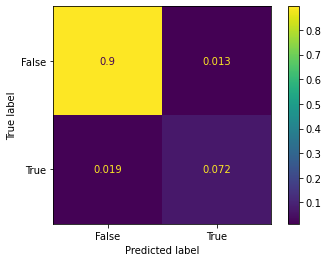

In [68]:
dtc.fit(xtrain1,ytrain1)
print('accuracy score=',dtc.score(xtest1,ytest1))
plot_confusion_matrix(dtc,xtest1,ytest1,normalize='all')

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler=MinMaxScaler(copy=False)

df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']]=scaler.fit_transform(df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']])


opDF=df[(df['operation']==True)]
nopDF=df[(df['operation']!=True)]


nopPer=.1
mixDF=opDF.copy()
mixDF=mixDF.append(nopDF.sample(int(nopPer*len(opDF))))
print('op/no-op ratio=',len(mixDF[mixDF['operation']==True])/len(mixDF[mixDF['operation']==False]))

x2=mixDF[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y2=mixDF[['theta_out','qc_out','qv_out','qr_out']].copy()

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size=0.30, random_state=20)

print(mixDF.mean())
print(mixDF.)

op/no-op ratio= 10.000035239599914
theta        0.166239
qc           0.019929
qv           0.176613
qr           0.015301
rho_dry      0.471578
z            0.374875
exner        0.588686
theta_out    0.167121
qc_out       0.019940
qv_out       0.175243
qr_out       0.015280
operation    0.909091
dtype: float64


In [67]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

stopTol=1e-5

linReg=LinearRegression()
dtr=DecisionTreeRegressor(min_samples_split=20,random_state=0)
mlpReg=MLPRegressor(hidden_layer_sizes=[100,100,100,100,100,100],tol=stopTol,early_stopping=True,verbose=False)


In [68]:
mlpReg.fit(xtrain2,ytrain2)
ypred=mlpReg.predict(xtest2)

print('-------------------------------DNN (six 100 node layers)--------------------------')
print('# of Iterations:',mlpReg.n_iter_,'-----','Final Training Loss=',mlpReg.loss_)
print('R^2 test scores ----- AVG=',mlpReg.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values') )
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

-------------------------------DNN (six 100 node layers)--------------------------
# of Iterations: 20 ----- Final Training Loss= 2.482245693415436e-05
R^2 test scores ----- AVG= 0.9964505635750065 ----- by variable: [0.99983155 0.99814385 0.99992701 0.98789984]
MAE test scores ----- AVG= 0.001761226700424696 ----- by variable: [0.00167573 0.00155051 0.00150318 0.00231548]


In [38]:
linReg.fit(xtrain2,ytrain2)
ypred=linReg.predict(xtest2)

print('----------------------Linear Regressor Results---------------------')
print('# features:', linReg.rank_,)
print('R^2 test scores ----- AVG=',linReg.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values'))
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

----------------------Linear Regressor Results---------------------
# features: 7
R^2 test scores ----- AVG= 0.9707762797727527 ----- by variable: [0.99998294 0.93033138 0.99980183 0.95298897]
MAE test scores ----- AVG= 0.0019435176655494468 ----- by variable: [0.00036586 0.00304804 0.0014645  0.00289566]


In [39]:
dtr.fit(xtrain2,ytrain2)
ypred=dtr.predict(xtest2)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',dtr.n_features_,'-----','# outputs:',dtr.n_outputs_)
print('R^2 test scores ----- AVG=',dtr.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values') )
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

-----------------------------DT Regressor Results--------------------------
# features: 7 ----- # outputs: 4
R^2 test scores ----- AVG= 0.9964810144456607 ----- by variable: [0.99998309 0.99503701 0.99995011 0.99095384]
MAE test scores ----- AVG= 0.0004788738047126591 ----- by variable: [0.0002074  0.00059884 0.00034451 0.00076474]


In [15]:
var='ml_out_qr'
col=2

print(np.mean(ds[var]), np.std(ds[var]),np.min(ds[var]), np.max((ds[var])))

2.491729835786887e-05 0.00041271428321975755 0.0 0.020895973256408917


In [ ]:
#converts data to dict then pandas dataframe
#creates colormap of correlation matrix

num1=0
num2=24000000

inputs={ 'theta': ds['ml_in_theta'][num1:num2,1],
       'qc': ds['ml_in_qc'][num1:num2,1],
       'qv': ds['ml_in_qv'][num1:num2,1],
       'qr': ds['ml_in_qr'][num1:num2,1],
       'rho_dry': ds['ml_in_rho_dry'][num1:num2,1],
       'z': ds['ml_in_z'][num1:num2],
       'exner': ds['ml_in_exner'][num1:num2,1],
       'theta_out': ds['ml_out_theta'][num1:num2],
       'qc_out': ds['ml_out_qc'][num1:num2],
       'qv_out': ds['ml_out_qv'][num1:num2],
       'qr_out': ds['ml_out_qr'][num1:num2]}

df=pd.DataFrame(inputs,columns=['theta','qc','qv','qr','rho_dry','z','exner','theta_out','qc_out','qv_out','qr_out'])

plt.figure(figsize=(10,10))
sb.heatmap(df.corr(),annot=True, cmap='coolwarm')

In [9]:
print(df.corr())

              theta        qc        qv        qr   rho_dry         z  \
theta      1.000000 -0.053497 -0.505912 -0.043525 -0.830402  0.917968   
qc        -0.053497  1.000000  0.037600  0.333866  0.042368 -0.051043   
qv        -0.505912  0.037600  1.000000  0.046578  0.852126 -0.754595   
qr        -0.043525  0.333866  0.046578  1.000000  0.048608 -0.051834   
rho_dry   -0.830402  0.042368  0.852126  0.048608  1.000000 -0.981761   
z          0.917968 -0.051043 -0.754595 -0.051834 -0.981761  1.000000   
exner     -0.895436  0.049731  0.780281  0.051801  0.990237 -0.998527   
theta_out  0.999997 -0.051733 -0.505865 -0.042464 -0.830391  0.917952   
qc_out    -0.053759  0.962126  0.043958  0.253745  0.045585 -0.053017   
qv_out    -0.505792  0.030075  0.999955  0.042369  0.852115 -0.754512   
qr_out    -0.044225  0.416287  0.052149  0.971785  0.051632 -0.054208   

              exner  theta_out    qc_out    qv_out    qr_out  
theta     -0.895436   0.999997 -0.053759 -0.505792 -0.044225

(array([1.78116311e+03, 1.62930610e+02, 1.23598587e+02, 7.67300796e+01,
        3.76161266e+01, 5.62964702e+01, 6.06763074e+01, 1.88421048e+01,
        3.29677965e+01, 3.75209127e+01, 2.06460490e+01, 4.68580131e+01,
        1.11942824e+01, 1.72326835e+01, 4.69025486e+01, 6.87459374e+00,
        1.07351059e+01, 1.69905537e+01, 4.27960673e+01, 3.70822123e+00,
        8.77579938e+00, 1.10837115e+01, 1.86396474e+01, 3.51810067e+01,
        1.92654481e+00, 4.71999639e+00, 1.03560422e+01, 1.21369508e+01,
        2.27778667e+01, 2.42109375e+01, 9.05555406e-01, 1.69106969e+00,
        4.47991415e+00, 1.04837618e+01, 1.40660551e+01, 4.46854992e+01,
        1.46404096e+00, 9.21680333e-01, 9.63400381e-01, 1.68671852e+00,
        9.98004985e+00, 2.74617739e+01, 1.59586096e+02, 2.66388908e+01,
        1.21525638e+00, 1.10724496e+00, 8.12645114e-01, 5.97134189e-01,
        4.58920532e-01, 1.20041121e-01]),
 array([7.82831908e-06, 3.33411209e-04, 6.58994098e-04, 9.84576988e-04,
        1.31015988e-03

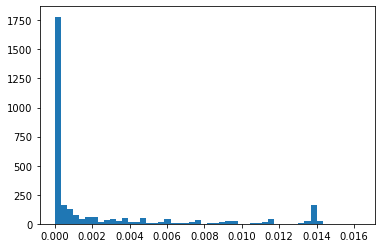

In [10]:
#used to create histogram for each input
plt.hist(ds['ml_out_qv'][0:23999999],bins=50, density=True)

<AxesSubplot:xlabel='z', ylabel='qr_out'>

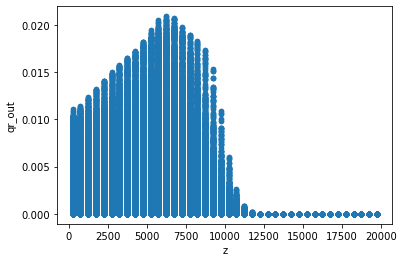

In [11]:
#used to create scttaer plot for inputs vs height
df.plot.scatter(x='z',y='qr_out')

In [12]:

#splits data operation and no operation sets:
#no operation data are entries where inputs=outputs
#ds['ml_in_theta'][i,1]==ds['ml_out_theta'][i] and ds['ml_in_qv'][i,1]==ds['ml_out_qv'][i] and ds['ml_in_qc'][i,1]==ds['ml_out_qc'][i] and ds['ml_in_qr'][i,1]==ds['ml_out_qr'][i]:



opDF= df[(df['theta']!=df['theta_out']) | (df['qv']!=df['qv_out']) | (df['qc']!=df['qc_out']) | (df['qr']!=df['qr_out'])]
noOpDF=df[(df['theta']==df['theta_out']) & (df['qv']==df['qv_out']) & (df['qc']==df['qc_out']) & (df['qr']==df['qr_out'])]

print('% of no-op data:',len(noOpDF)/len(df)*100,'----- % of op data:', len(opDF)/len(df)*100)

opDF=opDF.round(9)
noOpDF=noOpDF.round(9)



% of no-op data: 21.716191666666667 ----- % of op data: 78.28380833333334


In [23]:
#creates input dataset, so that 10% of the data is no-op data, then normalizes the inputs
from sklearn.preprocessing import MinMaxScaler

noOp_samples=math.floor(len(opDF)/(.9))
dfConcat=opDF.append(noOpDF[0:noOp_samples])

scaler=MinMaxScaler(copy=False)
dfConcat[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']]=scaler.fit_transform(dfConcat[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']])

x=dfConcat[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y=dfConcat[['theta_out','qc_out','qv_out','qr_out']].copy()


#normX=(x-x.mean())/x.std()
print(scaler.data_range_)

[1.88039341e+02 3.79668700e-03 1.62719870e-02 2.10476940e-02
 1.04164544e+00 5.54290557e-01 1.95000000e+04 1.88162028e+02
 3.76632800e-03 1.62791450e-02 2.08959730e-02]


In [24]:
#split data, create/fit 2 layer neural net

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split







In [27]:
reg=MLPRegressor(hidden_layer_sizes=[1],activation='logistic', solver='sgd',learning_rate_init=1e-4,learning_rate='adaptive', batch_size=1000, max_iter=250, early_stopping=True, verbose=True)
reg.fit(xtrain,ytrain)


Iteration 1, loss = 0.01948908
Validation score: -0.002441
Iteration 2, loss = 0.01745822
Validation score: -0.373793
Iteration 3, loss = 0.01589416
Validation score: -1.169560
Iteration 4, loss = 0.01311802
Validation score: -1.969158
Iteration 5, loss = 0.00974451
Validation score: -1.916055
Iteration 6, loss = 0.00721680
Validation score: -1.150646
Iteration 7, loss = 0.00594495
Validation score: -0.426499
Iteration 8, loss = 0.00543011
Validation score: -0.001409
Iteration 9, loss = 0.00523207
Validation score: 0.203290
Iteration 10, loss = 0.00515125
Validation score: 0.294001
Iteration 11, loss = 0.00511344
Validation score: 0.333004
Iteration 12, loss = 0.00509190
Validation score: 0.349719
Iteration 13, loss = 0.00507672
Validation score: 0.356986
Iteration 14, loss = 0.00506410
Validation score: 0.360260
Iteration 15, loss = 0.00505256
Validation score: 0.361842
Iteration 16, loss = 0.00504151
Validation score: 0.362697
Iteration 17, loss = 0.00503070
Validation score: 0.36323

MLPRegressor(activation='logistic', batch_size=1000, early_stopping=True,
             hidden_layer_sizes=[1], learning_rate='adaptive',
             learning_rate_init=0.0001, max_iter=250, solver='sgd',
             verbose=True)

# of Iterations: 113 ----- Final Training Loss= 0.004593863497962106
R^2 test scores ----- AVG= 0.37497788123747144 ----- by variable: [0.80224781 0.00199109 0.69354398 0.00212864]


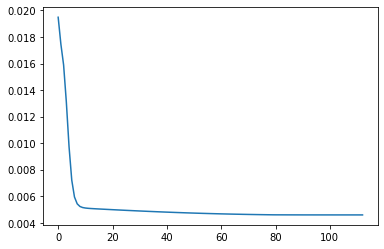

In [28]:
from sklearn.metrics import r2_score

ypred=reg.predict(xtest)
plt.plot(reg.loss_curve_)

print('# of Iterations:',reg.n_iter_,'-----','Final Training Loss=',reg.loss_)
print('R^2 test scores ----- AVG=',reg.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypred,multioutput='raw_values') )


In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

regTree= DecisionTreeRegressor(random_state=0, criterion='mse')
regTree.fit(xtrain,ytrain)



DecisionTreeRegressor(random_state=0)

In [30]:
regRF= RandomForestRegressor(random_state=0, n_estimators=10)
regRF.fit(xtrain,ytrain)


RandomForestRegressor(n_estimators=10, random_state=0)

In [31]:

ypredTree=regTree.predict(xtest)
ypredRF=regRF.predict(xtest)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',regTree.n_features_,'-----','# outputs:',regTree.n_outputs_)
print('R^2 test scores ----- AVG=',regTree.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredTree,multioutput='raw_values') )


print('-----------------------------Random Forrest Results------------------------')
print('# features:',regRF.n_features_,'-----','# outputs:',regRF.n_outputs_)
print('R^2 test scores ----- AVG=',regRF.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredRF,multioutput='raw_values') )


-----------------------------DT Regressor Results--------------------------
# features: 7 ----- # outputs: 4
R^2 test scores ----- AVG= 0.9983830203044269 ----- by variable: [0.99999956 0.99789049 0.9999981  0.99564394]
-----------------------------Random Forrest Results------------------------
# features: 7 ----- # outputs: 4
R^2 test scores ----- AVG= 0.9987573438665126 ----- by variable: [0.99999975 0.99859625 0.99999894 0.99643443]


In [32]:
from sklearn.linear_model import LinearRegression

lrReg=LinearRegression().fit(xtrain,ytrain)
lrReg.score(xtest,ytest)

ypredLR=lrReg.predict(xtest)
print('# features:', lrReg.rank_,)
print('R^2 test scores ----- AVG=',lrReg.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredLR,multioutput='raw_values') )

# features: 7
R^2 test scores ----- AVG= 0.9712993442698682 ----- by variable: [0.99999834 0.93172964 0.99996965 0.95349974]


In [33]:
lrReg.coef_

array([[ 1.00002602e+00,  2.33198821e-02,  4.11387821e-04,
         7.51601947e-03, -2.55872626e-03,  9.55385978e-04,
        -1.79917016e-03],
       [ 2.41779745e-03,  1.00022728e+00,  6.41949065e-03,
        -7.62205924e-02, -3.98924411e-02,  6.97949824e-02,
         3.34179763e-02],
       [-2.81146158e-03, -9.32488445e-02,  9.97716136e-01,
        -2.48423551e-02,  1.14685239e-02, -5.85070077e-03,
         6.31368150e-03],
       [ 1.55071922e-03,  1.09577796e-01, -2.17186871e-03,
         9.45724663e-01,  2.20916777e-02, -5.87919546e-02,
        -4.06680968e-02]])

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

GBreg=MultiOutputRegressor(GradientBoostingRegressor(n_estimators=10, verbose=1))
GBreg.fit(xtrain,ytrain)

ypredGB=GBreg.predict(xtest)

print('R^2 test scores ----- AVG=',GBreg.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredGB,multioutput='raw_values') )


      Iter       Train Loss   Remaining Time 
         1           0.0637            5.56m
         2           0.0518            4.95m
         3           0.0421            4.34m
         4           0.0342            3.73m
         5           0.0278            3.13m
         6           0.0226            2.51m
         7           0.0184            1.89m
         8           0.0149            1.26m
         9           0.0121           37.67s
        10           0.0099            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0003            6.00m
         2           0.0003            5.23m
         3           0.0002            4.55m
         4           0.0002            3.97m
         5           0.0001            3.31m
         6           0.0001            2.63m
         7           0.0001            1.98m
         8           0.0001            1.33m
         9           0.0001           39.90s
        10           0.0001            0.00s
      It

In [35]:
from sklearn.linear_model import Ridge

ridgeReg=Ridge(solver='saga').fit(xtrain,ytrain)


In [36]:
ypredRidge=ridgeReg.predict(xtest)

print('R^2 test scores ----- AVG=',ridgeReg.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredRidge,multioutput='raw_values') )

R^2 test scores ----- AVG= 0.971298627533584 ----- by variable: [0.99999834 0.93172444 0.99996965 0.95350208]


In [37]:
from sklearn.cross_decomposition import PLSRegression

plsReg=PLSRegression(scale=False, copy=False).fit(xtrain,ytrain)
ypredpls=plsReg.predict(xtest)

print('# iterations:', plsReg.n_iter_,'----- # features used:', plsReg.n_features_in_)
print('R^2 test scores ----- AVG=',plsReg.score(xtest,ytest),'----- by variable:',r2_score(ytest,ypredpls,multioutput='raw_values') )

# iterations: [4, 4] ----- # features used: 7
R^2 test scores ----- AVG= 0.49178849279006115 ----- by variable: [0.97855259 0.00284545 0.98266296 0.00309296]


In [38]:


print('------------------Mean Abs. Error Results------------------------')
print('')

------------------Mean Abs. Error Results------------------------



In [23]:
#Removing 10% of samples at beginning
#Triaining and testing classifiers w/o altering op/no-op ratio
#Training and testing regressors w/ 90% op data
#Testing both networks on removed 10% by feeding data through
#classifier and feeding labeled op samples to regressor

scaler=MinMaxScaler(copy=False)

df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']]=scaler.fit_transform(df[['theta','qc','qv','qr','rho_dry','exner','z','theta_out','qc_out','qv_out','qr_out']])

print(len(df))
valid=df.sample(int(np.floor(0.1*len(df))))
print(len(valid))
df=df.drop(valid.index)
print(len(df))

opDF=df[(df['operation']==True)]
nopDF=df[(df['operation']!=True)]



#DF to control ratio of op/no-op data for training
#'nopPer' is the number of no-op samples to use for every op sample
#nopPer=1
#mixDF=opDF.copy()
#mixDF=mixDF.append(nopDF.sample(nopPer*len(opDF)))
print('op/no-op ratio=',len(df[df['operation']==True])/len(df[df['operation']==False]))

x1=df[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y1=df[['operation']]

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1, y1, test_size=0.30, random_state=23)

df.head()

19440000
1944000
17496000
op/no-op ratio= 0.07632925216956074


,theta,qc,qv,qr,rho_dry,z,exner,theta_out,qc_out,qv_out,qr_out,operation
0,0.029502,0.0,0.859893,0.0,0.977363,0.0,0.996994,0.030135,0.0,0.859515,0.0,False
1,0.029502,0.0,0.859893,0.0,0.977363,0.0,0.996994,0.030135,0.0,0.859515,0.0,False
2,0.029502,0.0,0.859893,0.0,0.977363,0.0,0.996994,0.030135,0.0,0.859515,0.0,False
4,0.029502,0.0,0.859893,0.0,0.977363,0.0,0.996994,0.030135,0.0,0.859515,0.0,False
5,0.029502,0.0,0.859893,0.0,0.977363,0.0,0.996994,0.030135,0.0,0.859515,0.0,False


In [24]:
stopTol=1e-5
dtc=DecisionTreeClassifier(min_samples_split=20,random_state=0)
dnn100=MLPClassifier(hidden_layer_sizes=[100,100,100,100,100,100],tol=stopTol,early_stopping=True,verbose=True)
dnn64=MLPClassifier(hidden_layer_sizes=[64,64,64,64,64,64,64,64,64,64],tol=stopTol,early_stopping=True,verbose=True)

accuracy score= 0.9712048468221308


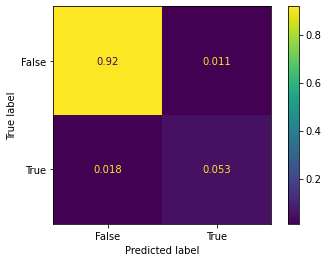

In [25]:
dtc.fit(xtrain1,ytrain1)
print('accuracy score=',dtc.score(xtest1,ytest1))
plot_confusion_matrix(dtc,xtest1,ytest1,normalize='all')

/ccs/home/zaneb/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Iteration 1, loss = 0.18304104
Validation score: 0.949492
Iteration 2, loss = 0.17289117
Validation score: 0.955477
Iteration 3, loss = 0.15827686
Validation score: 0.954172
Iteration 4, loss = 0.14609359
Validation score: 0.958141
Iteration 5, loss = 0.14095980
Validation score: 0.957887
Iteration 6, loss = 0.13812010
Validation score: 0.959030
Iteration 7, loss = 0.13713896
Validation score: 0.959757
Iteration 8, loss = 0.13586580
Validation score: 0.958185
Iteration 9, loss = 0.13484864
Validation score: 0.961262
Iteration 10, loss = 0.13368510
Validation score: 0.959901
Iteration 11, loss = 0.13337430
Validation score: 0.960553
Iteration 12, loss = 0.13240106
Validation score: 0.961480
Iteration 13, loss = 0.13204754
Validation score: 0.960435
Iteration 14, loss = 0.13204015
Validation score: 0.960437
Iteration 15, loss = 0.13129263
Validation score: 0.961049
Iteration 16, loss = 0.13073795
Validation score: 0.958405
Iteration 17, loss = 0.13070506
Validation score: 0.960272
Iterat

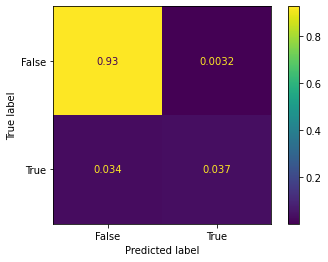

In [26]:
dnn100.fit(xtrain1,ytrain1)
print('accuracy score=',dnn100.score(xtest1,ytest1))
plot_confusion_matrix(dnn100,xtest1,ytest1,normalize='all')

In [ ]:
dnn64.fit(xtrain1,ytrain1)
print('accuracy score=',dnn64.score(xtest1,ytest1))
plot_confusion_matrix(dnn64,xtest1,ytest1,normalize='all')

/ccs/home/zaneb/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Iteration 1, loss = 0.17734510
Validation score: 0.948855
Iteration 2, loss = 0.17257867
Validation score: 0.953600
Iteration 3, loss = 0.16173109
Validation score: 0.956516
Iteration 4, loss = 0.15307117
Validation score: 0.957548
Iteration 5, loss = 0.15228331
Validation score: 0.957998
Iteration 6, loss = 0.14581291
Validation score: 0.959045
Iteration 7, loss = 0.14165946
Validation score: 0.959808
Iteration 8, loss = 0.14098013
Validation score: 0.959051


In [ ]:
mixdf=opDF.copy()
mixDF=mixDF.append(nopDF.sample(int(np.floor(.1*len(opDF)))))
print('op/no-op ratio=',len(mixDF[mixDF['operation']==True])/len(mixDF[mixDF['operation']==False]))

x1=mixDF[['theta','qc','qv','qr','rho_dry','exner','z']].copy()
y1=mixDF[['theta_out','qc_out','qv_out','qr_out']].copy()

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x1, y1, test_size=0.30, random_state=23)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

dtr1= DecisionTreeRegressor(random_state=0, criterion='mse')
dtr2= DecisionTreeRegressor(random_state=0, criterion='mae')
reg100=MLPRegressor(hidden_layer_sizes=[100,100,100,100,100,100], early_stopping=True, verbose=True)
reg64=reg=MLPRegressor(hidden_layer_sizes=[64,64,64,64,64,64,64,64,64,64], early_stopping=True, verbose=True)

In [ ]:
dtr1.fit(xtrain2,ytrain2)
ypred=dtr1.predict(xtest2)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',dtr1.n_features_,'-----','# outputs:',dtr1.n_outputs_)
print('R^2 test scores ----- AVG=',dtr1.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values') )
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

In [ ]:
dtr2.fit(xtrain2,ytrain2)
ypred=dtr2.predict(xtest2)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',dtr2.n_features_,'-----','# outputs:',dtr2.n_outputs_)
print('R^2 test scores ----- AVG=',dtr2.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values') )
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

In [ ]:
reg100.fit(xtrain2,ytrain2)
ypred=reg100.predict(xtest2)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',reg100.n_features_,'-----','# outputs:',reg100.n_outputs_)
print('R^2 test scores ----- AVG=',dtr1.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values') )
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

In [ ]:
reg64.fit(xtrain2,ytrain2)
ypred=reg64.predict(xtest2)

print('-----------------------------DT Regressor Results--------------------------')
print('# features:',reg64.n_features_,'-----','# outputs:',reg64.n_outputs_)
print('R^2 test scores ----- AVG=',dtr1.score(xtest2,ytest2),'----- by variable:',r2_score(ytest2,ypred,multioutput='raw_values') )
print('MAE test scores ----- AVG=',mean_absolute_error(ytest2,ypred),'----- by variable:',mean_absolute_error(ytest2,ypred,multioutput='raw_values'))

In [ ]:
#Test classifiers and regression models on valid set
#by if classifier.predict(valid_i)==True >>>  reg.predict(valid_i)